# Chuẩn bị thư viện cần thiết

In [14]:
!pip install pandas pandas_datareader
!pip install ccxt
import pandas as pd
import pandas_datareader as web
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import ccxt
import time
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, RepeatVector, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l1, l2, l1_l2

# Các function cần thiết (nhận data, xử lý data và train model)

In [15]:
# Hàm để lấy tất cả dữ liệu về tiền điện tử
def fetch_all_crypto_data(crypto_id, time_frame='1d'):
    # Khởi tạo sàn giao dịch Binance với rate limit được kích hoạt
    exchange = ccxt.binanceus({
        'enableRateLimit': True   # Kích hoạt rate limit để giữ khoảng cách giữa các yêu cầu
    })

    # Lấy thời gian hiện tại theo milliseconds
    now = exchange.milliseconds()
    all_ohlcv = [] # Danh sách chứa tất cả dữ liệu OHLCV

    # Bắt đầu từ ngày sớm nhất bạn muốn lấy dữ liệu
    since = exchange.parse8601('2014-01-01T00:00:00Z')

    # Lặp để lấy dữ liệu cho đến thời điểm hiện tại
    while since < now:
        ohlcv = exchange.fetch_ohlcv(crypto_id, time_frame, since)
        if not ohlcv:
            break # Nếu không có dữ liệu thì dừng vòng lặp
        all_ohlcv.extend(ohlcv)
        # Cập nhật 'since' để lấy dữ liệu cho khoảng thời gian tiếp theo
        since = ohlcv[-1][0] + exchange.parse_timeframe(time_frame) * 1000  # Add one timeframe to 'since'

        # rate limit
        exchange.rateLimit = 2000
        time.sleep(exchange.rateLimit / 1000)  # Tạm dừng thực thi theo rate limit để tránh bị khóa

    df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df


In [16]:
# Hàm chuẩn bị dữ liệu đa bước
def prepare_multistep_data(df, column, n_steps_in, n_steps_out, split_ratio=0.8):
    # Lọc cột dữ liệu cần thiết từ DataFrame
    data = df.filter([column])
    # Chuyển DataFrame thành mảng numpy
    dataset = data.values

    # Tính toán độ dài của dữ liệu huấn luyện dựa trên tỷ lệ phân chia
    train_data_len = math.ceil(len(dataset) * split_ratio)

    # Chuẩn hóa dữ liệu
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    # Tạo dữ liệu huấn luyện
    train_data = scaled_data[0:train_data_len, :]
    x_train, y_train = [], []

    # Lặp qua dữ liệu để tạo các mẫu dữ liệu đa bước
    for i in range(n_steps_in, len(train_data) - n_steps_out +1):
        # Mẫu đầu vào x_train bao gồm n_steps_in điểm dữ liệu liên tiếp
        x_train.append(train_data[i - n_steps_in:i, 0])
        # Mẫu đầu ra y_train bao gồm n_steps_out điểm dữ liệu tiếp theo sau mỗi mẫu x_train
        y_train.append(train_data[i:i + n_steps_out, 0])

    # Chuyển danh sách thành mảng numpy và định hình lại cho phù hợp với mô hình học sâu
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Tạo dữ liệu kiểm tra tương tự (đang bỏ qua bước này)

    return x_train, y_train, scaler, train_data_len, dataset


In [17]:
def build_and_train_multistep_model(x_train, y_train, n_steps_out, epochs=100, batch_size=32):
    # Tạo mô hình Sequential
    model = Sequential()
    # Thêm lớp LSTM hai chiều với 100 nút, trả về trạng thái ở mọi bước thời gian
    model.add(Bidirectional(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1))))
    # Thêm lớp Dropout để giảm overfitting
    model.add(Dropout(0.2))
    # Thêm một lớp LSTM hai chiều khác
    model.add(Bidirectional(LSTM(100, return_sequences=False)))
    # Thêm lớp Dropout thứ hai
    model.add(Dropout(0.2))
    # Thêm lớp Dense để dự đoán n_steps_out bước tiếp theo
    model.add(Dense(n_steps_out, activation='relu'))

    # Biên dịch mô hình
    model.compile(optimizer='adam', loss='mae')
    # Tạo callback EarlyStopping để dừng sớm nếu mô hình không cải thiện
    early_stopping = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)
    # Tạo callback ModelCheckpoint để lưu mô hình tốt nhất
    model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
    # Tạo callback ReduceLROnPlateau để giảm tốc độ học nếu mô hình không cải thiện
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=10)

    # Huấn luyện mô hình với dữ liệu đầu vào
    history = model.fit(
        x_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, model_checkpoint, reduce_lr]
    )

    return model, history


# Lấy dữ liệu BNB và ETH

In [18]:
bnb_df = fetch_all_crypto_data('BNB/USDT')

In [19]:
eth_df = fetch_all_crypto_data('ETH/USDT')

# Vẽ biểu đồ giá BNB và ETH

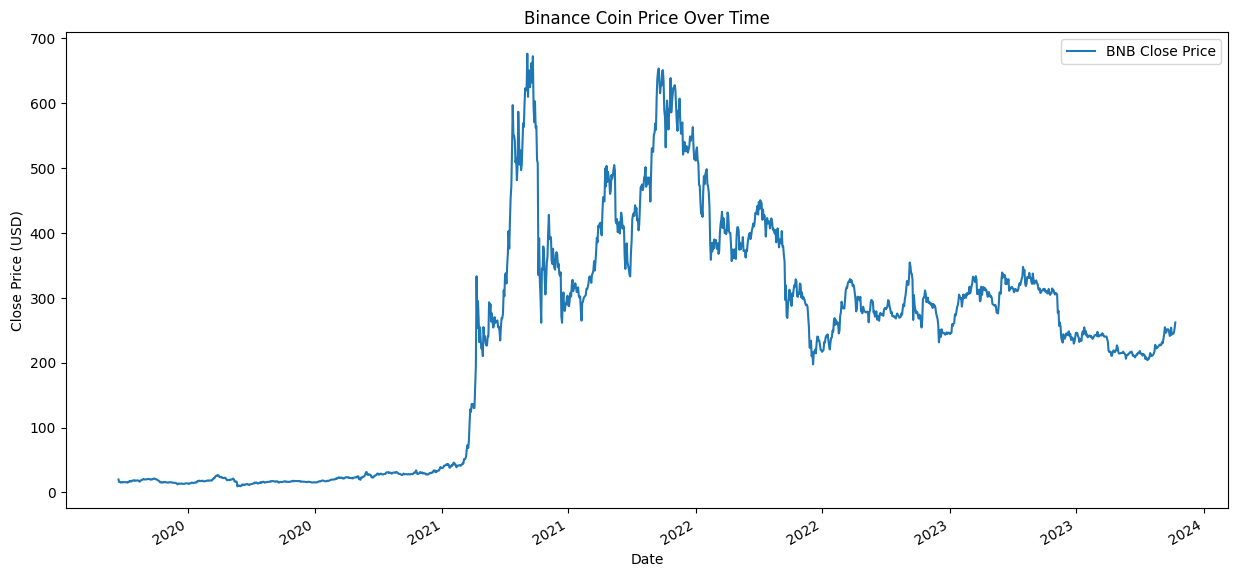

               open     high      low    close    volume
timestamp                                               
2019-09-23  19.8787  19.8787  19.8787  19.8787      0.10
2019-09-24  18.7526  18.7684  14.8282  15.8755  17466.73
2019-09-25  15.8134  16.3429  14.9626  16.0652   3215.02
2019-09-26  15.9926  16.2401  14.5001  15.2221   2935.23
2019-09-27  15.3026  15.7365  14.7586  15.6038   1657.48


In [20]:
# Sắp xếp DataFrame theo chỉ mục (ngày) theo thứ tự tăng dần
bnb_df.sort_index(ascending=True, inplace=True)

# Vẽ biểu đồ giá Binance Coin
plt.figure(figsize=(15, 7))  # Điều chỉnh kích thước theo nhu cầu
plt.plot(bnb_df.index, bnb_df['close'], label='BNB Close Price')

# Định dạng trục thời gian
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()  # Rotation

# Tiêu đề và nhãn
plt.title('Binance Coin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()

# Hiển thị biểu đồ với ngày
plt.show()

# Hiển thị một số hàng đầu tiên của tập dữ liệu
print(bnb_df.head())


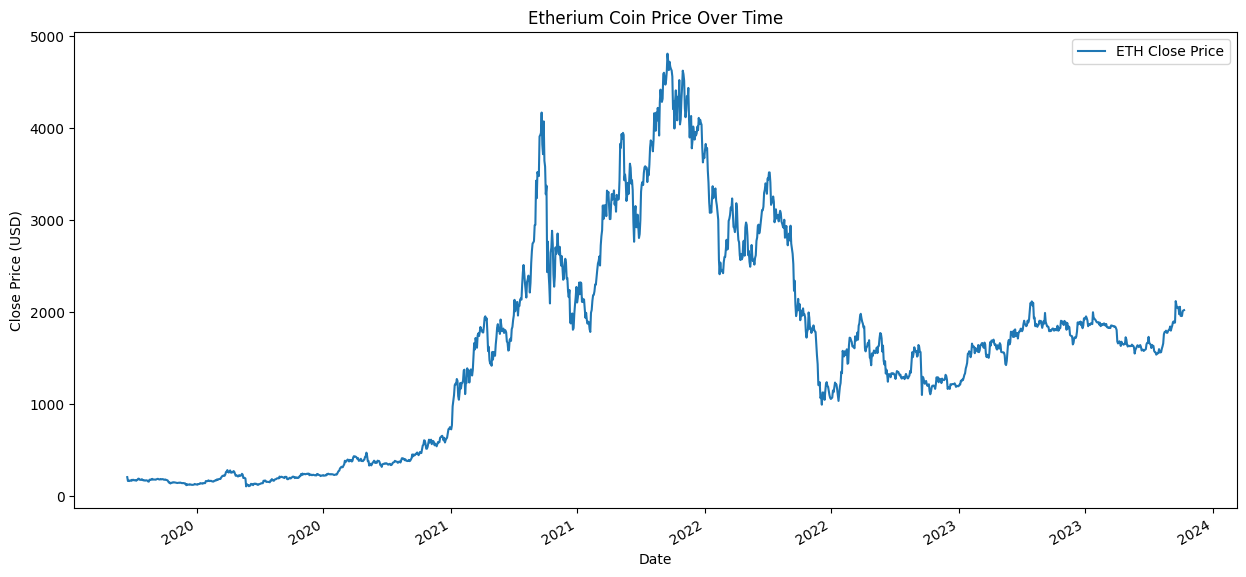

              open    high     low   close      volume
timestamp                                             
2019-09-23  209.55  209.55  209.55  209.55     0.01000
2019-09-24  195.50  195.50  152.56  167.09  2224.36708
2019-09-25  166.84  174.15  163.18  170.00   181.60286
2019-09-26  169.95  170.77  153.07  166.69   545.45350
2019-09-27  166.34  175.54  161.44  173.69   630.91688


In [21]:
# Sắp xếp DataFrame theo chỉ mục (ngày) theo thứ tự tăng dần
eth_df.sort_index(ascending=True, inplace=True)

# Vẽ biểu đồ giá Ethereum Coin
plt.figure(figsize=(15, 7))  # Điều chỉnh kích thước theo nhu cầu
plt.plot(eth_df.index, eth_df['close'], label='ETH Close Price')

# Định dạng trục thời gian
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()  # Rotation

# Tiêu đề và nhãn
plt.title('Etherium Coin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()

# Hiển thị biểu đồ với ngày
plt.show()

# Hiển thị một số hàng đầu tiên của tập dữ liệu
print(eth_df.head())

# Chuẩn bị data để train

In [31]:
n_steps_in, n_steps_out = 60, 180  # Ví dụ: dự đoán 180 ngày dựa trên 60 ngày trước đó
bnb_x_train, bnb_y_train, bnb_scaler, bnb_train_len, bnb_dataset = prepare_multistep_data(bnb_df, 'close', n_steps_in, n_steps_out)
eth_x_train, eth_y_train, eth_scaler, eth_train_len, eth_dataset = prepare_multistep_data(eth_df, 'close', n_steps_in, n_steps_out)

# Train model cho ETH và BNB

In [32]:
bnb_model, bnb_history = build_and_train_multistep_model(bnb_x_train, bnb_y_train, n_steps_out, 50, 32)

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 0.1998

31/31 [==============================] - 19s 223ms/step - loss: 0.1998 - lr: 0.0010
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.1347

31/31 [==============================] - 9s 302ms/step - loss: 0.1347 - lr: 0.0010
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.1180

31/31 [==============================] - 8s 267ms/step - loss: 0.1180 - lr: 0.0010
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.1075

31/31 [==============================] - 9s 273ms/step - loss: 0.1075 - lr: 0.0010
Epoch 5/50
31/31 [==============================] - ETA: 0s - loss: 0.1124

31/31 [==============================] - 11s 372ms/step - loss: 0.1124 - lr: 0.0010
Epoch 6/50
31/31 [==============================] - ETA: 0s - loss: 0.1019

31/31 [==============================] - 8s 241ms/step - loss: 0.1019 - lr: 0.0010
Epoch 7/50
31/31 [==============================] - ETA: 0s - loss: 0.0977

31/31 [==============================] - 9s 306ms/step - loss: 0.0977 - lr: 0.0010
Epoch 8/50
31/31 [==============================] - ETA: 0s - loss: 0.1045

31/31 [==============================] - 7s 235ms/step - loss: 0.1045 - lr: 0.0010
Epoch 9/50
31/31 [==============================] - ETA: 0s - loss: 0.1221

31/31 [==============================] - 10s 313ms/step - loss: 0.1221 - lr: 0.0010
Epoch 10/50
31/31 [==============================] - ETA: 0s - loss: 0.1311

31/31 [==============================] - 7s 227ms/step - loss: 0.1311 - lr: 0.0010
Epoch 11/50
31/31 [==============================] - ETA: 0s - loss: 0.1145

31/31 [==============================] - 10s 332ms/step - loss: 0.1145 - lr: 0.0010
Epoch 12/50
31/31 [==============================] - ETA: 0s - loss: 0.1129

31/31 [==============================] - 7s 219ms/step - loss: 0.1129 - lr: 0.0010
Epoch 13/50
31/31 [==============================] - ETA: 0s - loss: 0.1107

31/31 [==============================] - 10s 316ms/step - loss: 0.1107 - lr: 0.0010
Epoch 14/50
31/31 [==============================] - ETA: 0s - loss: 0.1046

31/31 [==============================] - 7s 222ms/step - loss: 0.1046 - lr: 0.0010
Epoch 15/50
31/31 [==============================] - ETA: 0s - loss: 0.1076

31/31 [==============================] - 10s 322ms/step - loss: 0.1076 - lr: 0.0010
Epoch 16/50
31/31 [==============================] - ETA: 0s - loss: 0.0987

31/31 [==============================] - 7s 220ms/step - loss: 0.0987 - lr: 0.0010
Epoch 17/50
31/31 [==============================] - ETA: 0s - loss: 0.0950

31/31 [==============================] - 10s 316ms/step - loss: 0.0950 - lr: 0.0010
Epoch 18/50
31/31 [==============================] - ETA: 0s - loss: 0.0935

31/31 [==============================] - 7s 238ms/step - loss: 0.0935 - lr: 0.0010
Epoch 19/50
31/31 [==============================] - ETA: 0s - loss: 0.0925

31/31 [==============================] - 9s 297ms/step - loss: 0.0925 - lr: 0.0010
Epoch 20/50
31/31 [==============================] - ETA: 0s - loss: 0.0908

31/31 [==============================] - 7s 240ms/step - loss: 0.0908 - lr: 0.0010
Epoch 21/50
31/31 [==============================] - ETA: 0s - loss: 0.0892

31/31 [==============================] - 9s 279ms/step - loss: 0.0892 - lr: 0.0010
Epoch 22/50
31/31 [==============================] - ETA: 0s - loss: 0.0921

31/31 [==============================] - 8s 275ms/step - loss: 0.0921 - lr: 0.0010
Epoch 23/50
31/31 [==============================] - ETA: 0s - loss: 0.0933

31/31 [==============================] - 8s 267ms/step - loss: 0.0933 - lr: 0.0010
Epoch 24/50
31/31 [==============================] - ETA: 0s - loss: 0.0885

31/31 [==============================] - 9s 291ms/step - loss: 0.0885 - lr: 0.0010
Epoch 25/50
31/31 [==============================] - ETA: 0s - loss: 0.0858

31/31 [==============================] - 8s 240ms/step - loss: 0.0858 - lr: 0.0010
Epoch 26/50
31/31 [==============================] - ETA: 0s - loss: 0.0863

31/31 [==============================] - 9s 305ms/step - loss: 0.0863 - lr: 0.0010
Epoch 27/50
31/31 [==============================] - ETA: 0s - loss: 0.0865

31/31 [==============================] - 7s 227ms/step - loss: 0.0865 - lr: 0.0010
Epoch 28/50
31/31 [==============================] - ETA: 0s - loss: 0.0868

31/31 [==============================] - 10s 327ms/step - loss: 0.0868 - lr: 0.0010
Epoch 29/50
31/31 [==============================] - ETA: 0s - loss: 0.0836

31/31 [==============================] - 7s 227ms/step - loss: 0.0836 - lr: 0.0010
Epoch 30/50
31/31 [==============================] - ETA: 0s - loss: 0.0849

31/31 [==============================] - 10s 314ms/step - loss: 0.0849 - lr: 0.0010
Epoch 31/50
31/31 [==============================] - ETA: 0s - loss: 0.0834

31/31 [==============================] - 7s 227ms/step - loss: 0.0834 - lr: 0.0010
Epoch 32/50
31/31 [==============================] - ETA: 0s - loss: 0.0847

31/31 [==============================] - 10s 325ms/step - loss: 0.0847 - lr: 0.0010
Epoch 33/50
31/31 [==============================] - ETA: 0s - loss: 0.0825

31/31 [==============================] - 7s 231ms/step - loss: 0.0825 - lr: 0.0010
Epoch 34/50
31/31 [==============================] - ETA: 0s - loss: 0.0824

31/31 [==============================] - 10s 315ms/step - loss: 0.0824 - lr: 0.0010
Epoch 35/50
31/31 [==============================] - ETA: 0s - loss: 0.0811

31/31 [==============================] - 7s 231ms/step - loss: 0.0811 - lr: 0.0010
Epoch 36/50
31/31 [==============================] - ETA: 0s - loss: 0.0802

31/31 [==============================] - 10s 306ms/step - loss: 0.0802 - lr: 0.0010
Epoch 37/50
31/31 [==============================] - ETA: 0s - loss: 0.0799

31/31 [==============================] - 8s 258ms/step - loss: 0.0799 - lr: 0.0010
Epoch 38/50
31/31 [==============================] - ETA: 0s - loss: 0.0797

31/31 [==============================] - 9s 281ms/step - loss: 0.0797 - lr: 0.0010
Epoch 39/50
31/31 [==============================] - ETA: 0s - loss: 0.0802

31/31 [==============================] - 9s 291ms/step - loss: 0.0802 - lr: 0.0010
Epoch 40/50
31/31 [==============================] - ETA: 0s - loss: 0.0785

31/31 [==============================] - 8s 251ms/step - loss: 0.0785 - lr: 0.0010
Epoch 41/50
31/31 [==============================] - ETA: 0s - loss: 0.0792

31/31 [==============================] - 10s 321ms/step - loss: 0.0792 - lr: 0.0010
Epoch 42/50
31/31 [==============================] - ETA: 0s - loss: 0.0776

31/31 [==============================] - 7s 225ms/step - loss: 0.0776 - lr: 0.0010
Epoch 43/50
31/31 [==============================] - ETA: 0s - loss: 0.0750

31/31 [==============================] - 13s 423ms/step - loss: 0.0750 - lr: 0.0010
Epoch 44/50
31/31 [==============================] - ETA: 0s - loss: 0.0785

31/31 [==============================] - 7s 225ms/step - loss: 0.0785 - lr: 0.0010
Epoch 45/50
31/31 [==============================] - ETA: 0s - loss: 0.0763

31/31 [==============================] - 9s 307ms/step - loss: 0.0763 - lr: 0.0010
Epoch 46/50
31/31 [==============================] - ETA: 0s - loss: 0.0788

31/31 [==============================] - 7s 224ms/step - loss: 0.0788 - lr: 0.0010
Epoch 47/50
31/31 [==============================] - ETA: 0s - loss: 0.0782

31/31 [==============================] - 10s 315ms/step - loss: 0.0782 - lr: 0.0010
Epoch 48/50
31/31 [==============================] - ETA: 0s - loss: 0.0784

31/31 [==============================] - 7s 226ms/step - loss: 0.0784 - lr: 0.0010
Epoch 49/50
31/31 [==============================] - ETA: 0s - loss: 0.0736

31/31 [==============================] - 10s 322ms/step - loss: 0.0736 - lr: 0.0010
Epoch 50/50
31/31 [==============================] - ETA: 0s - loss: 0.0722

31/31 [==============================] - 7s 230ms/step - loss: 0.0722 - lr: 0.0010


In [34]:
eth_model, eth_history = build_and_train_multistep_model(eth_x_train, eth_y_train, n_steps_out, 50, 32)

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 0.1941

31/31 [==============================] - 18s 223ms/step - loss: 0.1941 - lr: 0.0010
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.1339

31/31 [==============================] - 10s 317ms/step - loss: 0.1339 - lr: 0.0010
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.1170

31/31 [==============================] - 7s 230ms/step - loss: 0.1170 - lr: 0.0010
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.1070

31/31 [==============================] - 10s 312ms/step - loss: 0.1070 - lr: 0.0010
Epoch 5/50
31/31 [==============================] - ETA: 0s - loss: 0.1051

31/31 [==============================] - 11s 358ms/step - loss: 0.1051 - lr: 0.0010
Epoch 6/50
31/31 [==============================] - ETA: 0s - loss: 0.1025

31/31 [==============================] - 8s 267ms/step - loss: 0.1025 - lr: 0.0010
Epoch 7/50
31/31 [==============================] - ETA: 0s - loss: 0.1028

31/31 [==============================] - 9s 293ms/step - loss: 0.1028 - lr: 0.0010
Epoch 8/50
31/31 [==============================] - ETA: 0s - loss: 0.1049

31/31 [==============================] - 8s 240ms/step - loss: 0.1049 - lr: 0.0010
Epoch 9/50
31/31 [==============================] - ETA: 0s - loss: 0.0971

31/31 [==============================] - 9s 295ms/step - loss: 0.0971 - lr: 0.0010
Epoch 10/50
31/31 [==============================] - ETA: 0s - loss: 0.0978

31/31 [==============================] - 7s 226ms/step - loss: 0.0978 - lr: 0.0010
Epoch 11/50
31/31 [==============================] - ETA: 0s - loss: 0.0954

31/31 [==============================] - 10s 319ms/step - loss: 0.0954 - lr: 0.0010
Epoch 12/50
31/31 [==============================] - ETA: 0s - loss: 0.0953

31/31 [==============================] - 7s 220ms/step - loss: 0.0953 - lr: 0.0010
Epoch 13/50
31/31 [==============================] - ETA: 0s - loss: 0.0962

31/31 [==============================] - 10s 321ms/step - loss: 0.0962 - lr: 0.0010
Epoch 14/50
31/31 [==============================] - ETA: 0s - loss: 0.0944

31/31 [==============================] - 7s 222ms/step - loss: 0.0944 - lr: 0.0010
Epoch 15/50
31/31 [==============================] - ETA: 0s - loss: 0.0932

31/31 [==============================] - 10s 318ms/step - loss: 0.0932 - lr: 0.0010
Epoch 16/50
31/31 [==============================] - ETA: 0s - loss: 0.0924

31/31 [==============================] - 7s 227ms/step - loss: 0.0924 - lr: 0.0010
Epoch 17/50
31/31 [==============================] - ETA: 0s - loss: 0.0916

31/31 [==============================] - 10s 317ms/step - loss: 0.0916 - lr: 0.0010
Epoch 18/50
31/31 [==============================] - ETA: 0s - loss: 0.0918

31/31 [==============================] - 12s 399ms/step - loss: 0.0918 - lr: 0.0010
Epoch 19/50
31/31 [==============================] - ETA: 0s - loss: 0.0928

31/31 [==============================] - 15s 494ms/step - loss: 0.0928 - lr: 0.0010
Epoch 20/50
31/31 [==============================] - ETA: 0s - loss: 0.0918

31/31 [==============================] - 15s 490ms/step - loss: 0.0918 - lr: 0.0010
Epoch 21/50
31/31 [==============================] - ETA: 0s - loss: 0.0895

31/31 [==============================] - 10s 315ms/step - loss: 0.0895 - lr: 0.0010
Epoch 22/50
31/31 [==============================] - ETA: 0s - loss: 0.0889

31/31 [==============================] - 9s 308ms/step - loss: 0.0889 - lr: 0.0010
Epoch 23/50
31/31 [==============================] - ETA: 0s - loss: 0.0858

31/31 [==============================] - 8s 243ms/step - loss: 0.0858 - lr: 0.0010
Epoch 24/50
31/31 [==============================] - ETA: 0s - loss: 0.0850

31/31 [==============================] - 10s 315ms/step - loss: 0.0850 - lr: 0.0010
Epoch 25/50
31/31 [==============================] - ETA: 0s - loss: 0.0831

31/31 [==============================] - 7s 228ms/step - loss: 0.0831 - lr: 0.0010
Epoch 26/50
31/31 [==============================] - ETA: 0s - loss: 0.0835

31/31 [==============================] - 10s 314ms/step - loss: 0.0835 - lr: 0.0010
Epoch 27/50
31/31 [==============================] - ETA: 0s - loss: 0.0851

31/31 [==============================] - 7s 223ms/step - loss: 0.0851 - lr: 0.0010
Epoch 28/50
31/31 [==============================] - ETA: 0s - loss: 0.0793

31/31 [==============================] - 10s 319ms/step - loss: 0.0793 - lr: 0.0010
Epoch 29/50
31/31 [==============================] - ETA: 0s - loss: 0.0795

31/31 [==============================] - 7s 226ms/step - loss: 0.0795 - lr: 0.0010
Epoch 30/50
31/31 [==============================] - ETA: 0s - loss: 0.0821

31/31 [==============================] - 10s 338ms/step - loss: 0.0821 - lr: 0.0010
Epoch 31/50
31/31 [==============================] - ETA: 0s - loss: 0.0772

31/31 [==============================] - 7s 237ms/step - loss: 0.0772 - lr: 0.0010
Epoch 32/50
31/31 [==============================] - ETA: 0s - loss: 0.0770

31/31 [==============================] - 9s 297ms/step - loss: 0.0770 - lr: 0.0010
Epoch 33/50
31/31 [==============================] - ETA: 0s - loss: 0.0793

31/31 [==============================] - 8s 260ms/step - loss: 0.0793 - lr: 0.0010
Epoch 34/50
31/31 [==============================] - ETA: 0s - loss: 0.0695

31/31 [==============================] - 9s 271ms/step - loss: 0.0695 - lr: 0.0010
Epoch 35/50
31/31 [==============================] - ETA: 0s - loss: 0.0690

31/31 [==============================] - 9s 299ms/step - loss: 0.0690 - lr: 0.0010
Epoch 36/50
31/31 [==============================] - ETA: 0s - loss: 0.0790

31/31 [==============================] - 8s 251ms/step - loss: 0.0790 - lr: 0.0010
Epoch 37/50
31/31 [==============================] - ETA: 0s - loss: 0.0718

31/31 [==============================] - 10s 324ms/step - loss: 0.0718 - lr: 0.0010
Epoch 38/50
31/31 [==============================] - ETA: 0s - loss: 0.0691

31/31 [==============================] - 7s 224ms/step - loss: 0.0691 - lr: 0.0010
Epoch 39/50
31/31 [==============================] - ETA: 0s - loss: 0.0630

31/31 [==============================] - 10s 320ms/step - loss: 0.0630 - lr: 0.0010
Epoch 40/50
31/31 [==============================] - ETA: 0s - loss: 0.0795

31/31 [==============================] - 7s 228ms/step - loss: 0.0795 - lr: 0.0010
Epoch 41/50
31/31 [==============================] - ETA: 0s - loss: 0.0713

31/31 [==============================] - 12s 398ms/step - loss: 0.0713 - lr: 0.0010
Epoch 42/50
31/31 [==============================] - ETA: 0s - loss: 0.0661

31/31 [==============================] - 9s 298ms/step - loss: 0.0661 - lr: 0.0010
Epoch 43/50
31/31 [==============================] - ETA: 0s - loss: 0.0661

31/31 [==============================] - 10s 304ms/step - loss: 0.0661 - lr: 0.0010
Epoch 44/50
31/31 [==============================] - ETA: 0s - loss: 0.0720

31/31 [==============================] - 8s 252ms/step - loss: 0.0720 - lr: 0.0010
Epoch 45/50
31/31 [==============================] - ETA: 0s - loss: 0.0708

31/31 [==============================] - 9s 284ms/step - loss: 0.0708 - lr: 0.0010
Epoch 46/50
31/31 [==============================] - ETA: 0s - loss: 0.0672

31/31 [==============================] - 9s 279ms/step - loss: 0.0672 - lr: 0.0010
Epoch 47/50
31/31 [==============================] - ETA: 0s - loss: 0.0678

31/31 [==============================] - 8s 263ms/step - loss: 0.0678 - lr: 0.0010
Epoch 48/50
31/31 [==============================] - ETA: 0s - loss: 0.0615

31/31 [==============================] - 9s 303ms/step - loss: 0.0615 - lr: 0.0010
Epoch 49/50
31/31 [==============================] - ETA: 0s - loss: 0.0550

31/31 [==============================] - 8s 238ms/step - loss: 0.0550 - lr: 0.0010
Epoch 50/50
31/31 [==============================] - ETA: 0s - loss: 0.0594

31/31 [==============================] - 10s 314ms/step - loss: 0.0594 - lr: 0.0010


# Test bằng cách thử dự đoán bằng model đã train




In [35]:
def make_prediction(model, data, n_steps_in, scaler):
    # Lấy dữ liệu gần nhất
    last_data = data[-n_steps_in:]
    last_data_scaled = scaler.transform(last_data)

    # Reshape dữ liệu cho mô hình
    last_data_scaled = np.reshape(last_data_scaled, (1, last_data_scaled.shape[0], 1))

    # Dự đoán
    prediction_scaled = model.predict(last_data_scaled)
    prediction = scaler.inverse_transform(prediction_scaled)

    return prediction.flatten()

# Thực hiện dự đoán
bnb_predicted_prices = make_prediction(bnb_model, bnb_dataset, n_steps_in, bnb_scaler)
eth_predicted_prices = make_prediction(eth_model, eth_dataset, n_steps_in, eth_scaler)

1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


<ipython-input-36-e92ba8ce877b>:7: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_dates = pd.date_range(start=bnb_df.index[-1], periods=n_steps_out + 1, closed='right')


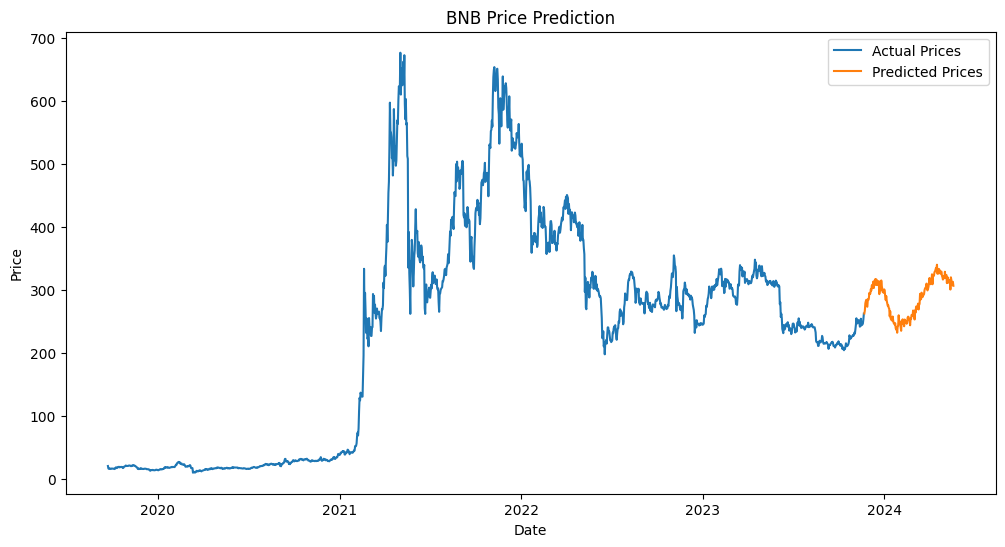

[262.1484069824219, 266.8090515136719, 278.3325500488281, 281.8955383300781, 283.9211120605469, 273.8690490722656, 272.8607177734375, 284.7831726074219, 283.47174072265625, 285.9176940917969, 294.84613037109375, 293.025390625, 293.8212890625, 300.87030029296875, 298.60577392578125, 306.9064636230469, 307.7636413574219, 302.4447326660156, 312.7743225097656, 302.6080017089844, 311.2309265136719, 315.0244140625, 316.71319580078125, 307.5546875, 316.35791015625, 314.0456237792969, 307.31060791015625, 307.561279296875, 307.5809326171875, 313.58203125, 292.8657531738281, 298.3929748535156, 303.8273620605469, 299.4444274902344, 314.5771789550781, 305.8744201660156, 301.5044250488281, 295.91180419921875, 299.6186828613281, 295.0517883300781, 300.4285888671875, 297.5299377441406, 288.43511962890625, 283.4033203125, 289.7886962890625, 282.2170104980469, 278.2179260253906, 274.463623046875, 275.15313720703125, 271.111083984375, 269.77239990234375, 257.6203918457031, 265.5723876953125, 253.9904632

In [36]:
import matplotlib.pyplot as plt

# Lấy dữ liệu thực tế
actual_prices = bnb_dataset.flatten()  # Sử dụng toàn bộ dữ liệu

# Tạo mốc thời gian cho dự đoán
predicted_dates = pd.date_range(start=bnb_df.index[-1], periods=n_steps_out + 1, closed='right')

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(bnb_df.index, actual_prices, label='Actual Prices')  # Sử dụng toàn bộ dữ liệu
plt.plot(predicted_dates, bnb_predicted_prices, label='Predicted Prices')
plt.title('BNB Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

print(bnb_predicted_prices.flatten().tolist())

<ipython-input-37-af161e5baf37>:7: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_dates = pd.date_range(start=eth_df.index[-1], periods=n_steps_out + 1, closed='right')


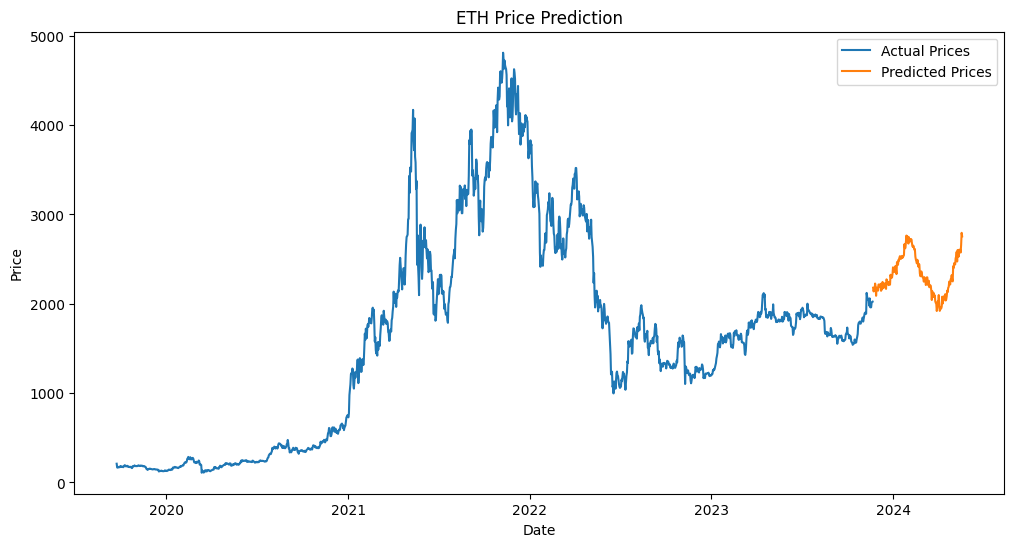

[2179.323974609375, 2137.771728515625, 2164.137939453125, 2152.804931640625, 2225.849365234375, 2192.6103515625, 2089.181396484375, 2175.519287109375, 2179.998291015625, 2165.691162109375, 2146.565673828125, 2215.83251953125, 2204.629638671875, 2190.54443359375, 2206.451171875, 2223.17724609375, 2145.10400390625, 2181.629150390625, 2161.47216796875, 2243.564453125, 2209.17431640625, 2175.0771484375, 2198.595947265625, 2200.94091796875, 2229.768798828125, 2220.443359375, 2166.451171875, 2272.69775390625, 2247.200927734375, 2226.903076171875, 2246.123291015625, 2208.60400390625, 2239.724853515625, 2228.89892578125, 2213.30908203125, 2324.30322265625, 2288.4091796875, 2314.66162109375, 2292.4306640625, 2332.885986328125, 2407.403564453125, 2377.05517578125, 2362.43017578125, 2355.469970703125, 2405.23974609375, 2422.6875, 2383.1005859375, 2331.913818359375, 2466.72705078125, 2464.887451171875, 2435.795166015625, 2491.828369140625, 2481.822265625, 2517.600830078125, 2532.623779296875, 2512

In [37]:
import matplotlib.pyplot as plt

# Lấy dữ liệu thực tế
actual_prices = eth_dataset.flatten()  # Sử dụng toàn bộ dữ liệu

# Tạo mốc thời gian cho dự đoán
predicted_dates = pd.date_range(start=eth_df.index[-1], periods=n_steps_out + 1, closed='right')

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(bnb_df.index, actual_prices, label='Actual Prices')  # Sử dụng toàn bộ dữ liệu
plt.plot(predicted_dates, eth_predicted_prices, label='Predicted Prices')
plt.title('ETH Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

print(eth_predicted_prices.flatten().tolist())

# Tải xuống model và scaler

In [38]:
# Lưu model
bnb_model.save('bnb_model.h5')

# Lưu scaler
import joblib
joblib.dump(bnb_scaler, 'bnb_scaler.gz')

import zipfile

# Tạo zip file
with zipfile.ZipFile('bnb_model_and_scaler.zip', 'w') as zipf:
    zipf.write('bnb_model.h5', arcname='bnb_model.h5')
    zipf.write('bnb_scaler.gz', arcname='bnb_scaler.gz')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
# Lưu model
eth_model.save('eth_model.h5')

# Lưu scaler
import joblib
joblib.dump(eth_scaler, 'eth_scaler.gz')

# Tạo zip file
with zipfile.ZipFile('eth_model_and_scaler.zip', 'w') as zipf:
    zipf.write('eth_model.h5', arcname='eth_model.h5')
    zipf.write('eth_scaler.gz', arcname='eth_scaler.gz')

In [40]:
from google.colab import files

files.download('bnb_model_and_scaler.zip')
files.download('eth_model_and_scaler.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>